In [200]:
import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [201]:
# Define the forward kinematics function
def FK(theta, alpha, a, d):
    theta_rad = np.deg2rad(theta)
    alpha_rad = np.deg2rad(alpha)
    T = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)*np.cos(alpha_rad), np.sin(theta_rad)*np.sin(alpha_rad), a*np.cos(theta_rad)],
        [np.sin(theta_rad), np.cos(theta_rad)*np.cos(alpha_rad), -np.cos(theta_rad)*np.sin(alpha_rad), a*np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])
    return T

In [202]:
# Function to compute the Jacobian numerically
def compute_jacobian(q, delta=1e-3):
    J = np.zeros((6, len(q)))
    current_pose = FK_chain(q)
    for i in range(len(q)):
        q_temp = q.copy()
        q_temp[i] += delta
        new_pose = FK_chain(q_temp)
        
        position_diff = (new_pose[:3, 3] - current_pose[:3, 3]) / delta
        rotation_diff = np.dot(new_pose[:3, :3], current_pose[:3, :3].T) - np.eye(3)
        omega = np.array([
            rotation_diff[2, 1] - rotation_diff[1, 2],
            rotation_diff[0, 2] - rotation_diff[2, 0],
            rotation_diff[1, 0] - rotation_diff[0, 1]
        ]) / (2 * delta)
        J[:3, i] = position_diff
        J[3:, i] = omega
    return J

In [203]:
# Function to compute the full FK chain
def FK_chain(q):
    T1 = FK(q[0], -90, 0.510, 0.690)
    T2 = FK(q[1] - 90, 0, 0.900, 0)
    T3 = FK(q[2], -90, 0.175, 0)
    T4 = FK(q[3], 90, 0, 0.960)
    T5 = FK(q[4] + 180, 90, 0, 0)
    T6 = FK(q[5], 0, 0, 0.135)
    return T1 @ T2 @ T3 @ T4 @ T5 @ T6

# Initialize joint angles

In [204]:
q = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# Desired pose
P_desired = np.array([1.30404, 0.85, 1.765])
R_desired = np.eye(3)
# Tolerance
epsilon = 1e-5
# Inverse kinematics using Newton-Raphson method
#for iteration in range(1000):
while(True):
    current_pose = FK_chain(q)
    P_current = current_pose[:3, 3]
    R_current = current_pose[:3, :3]

    delta_p = P_desired - P_current
    delta_r = 0.5 * np.array([
        R_desired[2, 1] - R_desired[1, 2],
        R_desired[0, 2] - R_desired[2, 0],
        R_desired[1, 0] - R_desired[0, 1]
    ])
    delta_x = np.hstack((delta_p, delta_r))

    if np.linalg.norm(delta_x) < epsilon:
        print("Converged")
        break

    J = compute_jacobian(q)
    J_pseudo_inverse = np.linalg.pinv(J)
    delta_q = np.dot(J_pseudo_inverse, delta_x)
    q += delta_q

print("Final joint angles:", q)


Converged
Final joint angles: [ 3.25977553e+01 -3.04099098e+00  3.03445647e+00  5.40927481e+06
 -5.78817923e+00 -5.40927495e+06]


In [209]:
print(q)
T0_6 = np.round(FK_chain(q),2)
print(T0_6)


[ 3.25977553e+01 -3.04099098e+00  3.03445647e+00  5.40927481e+06
 -5.78817923e+00 -5.40927495e+06]
[[ 0.01 -0.62  0.78  1.3 ]
 [ 0.    0.78  0.62  0.85]
 [-1.   -0.    0.01  1.77]
 [ 0.    0.    0.    1.  ]]


In [210]:
client = RemoteAPIClient()
sim = client.require('sim')
defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)
sim.setInt32Param(sim.intparam_idle_fps, 0)

1

In [211]:

#Getting names of joints 
joint_names = [f'joint_{i+1}' for i in range(6)]
#Handels of the joints
joint_handles=[sim.getObjectHandle(name) for name in joint_names]
#Assume that the EE is the connection of the last link with the end effector
EE_connection = sim.getObjectHandle("ik_1")
#Lets start
sim.addLog(sim.verbosity_scriptinfos, "Starting the program")
#Graph configuration
EE_graph = sim.getObjectHandle("graph")
EE_x = sim.addGraphStream(EE_graph,"End Effector X position","m",0,[0,1,1])
EE_y = sim.addGraphStream(EE_graph,"End Effector Y position","m",0,[0,0,1])
EE_z = sim.addGraphStream(EE_graph,"End Effector Z position","m",0,[0,1,0])
sim.addGraphCurve(EE_graph,"Position",3,[EE_x,EE_y,EE_z],[0,0,0],"m by m")

10000

In [212]:
client.setStepping(False)
sim.startSimulation()
#enable the position control for all joints
for i in range(len(joint_handles)):
    sim.setObjectInt32Parameter(joint_handles[i],2001,~0)
for i in range(len(q)):
    sim.setJointTargetPosition(joint_handles[i],np.radians(q[i]))

In [213]:
#### Robot base joint
Robotbase = joint_handles[0]
# Position of the End Effector
EE_pos = sim.getObjectPosition(EE_connection, -1)
print("Position of the end effector is:\n", EE_pos)
# Transformation matrix
EE_T = np.round(sim.getObjectMatrix(EE_connection, -1), decimals=3)
EE_T = EE_T.reshape(3, 4)
print("VREP matrix:\n", EE_T)
print("calculations matrix:\n", T0_6)
# Retrieve graph curve
ret = sim.getGraphCurve(EE_graph, 0, 0)

Position of the end effector is:
 [1.2985406842757015, 0.8963329893186487, 1.7822763715149585]
VREP matrix:
 [[ 0.085 -0.539  0.838  1.299]
 [ 0.054  0.842  0.536  0.896]
 [-0.995  0.     0.101  1.782]]
calculations matrix:
 [[ 0.01 -0.62  0.78  1.3 ]
 [ 0.    0.78  0.62  0.85]
 [-1.   -0.    0.01  1.77]
 [ 0.    0.    0.    1.  ]]


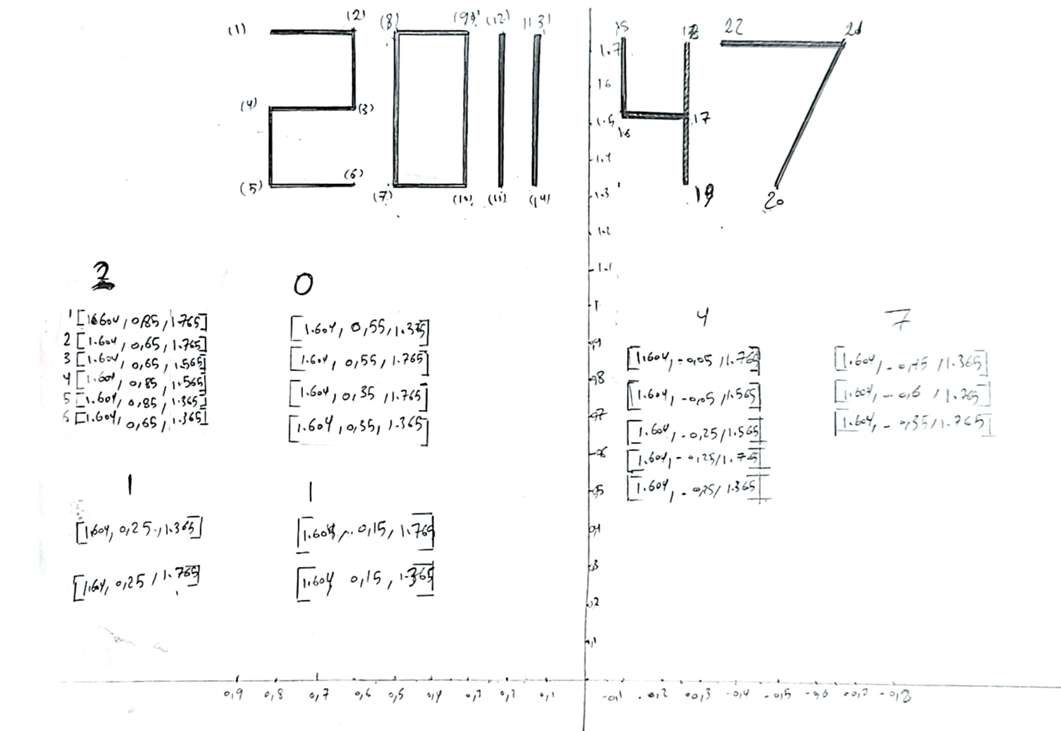

In [214]:


# Define the forward kinematics function
def FK(theta, alpha, a, d):
    theta_rad = np.deg2rad(theta)
    alpha_rad = np.deg2rad(alpha)
    T = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)*np.cos(alpha_rad), np.sin(theta_rad)*np.sin(alpha_rad), a*np.cos(theta_rad)],
        [np.sin(theta_rad), np.cos(theta_rad)*np.cos(alpha_rad), -np.cos(theta_rad)*np.sin(alpha_rad), a*np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])
    return T

# Function to compute the Jacobian numerically
def compute_jacobian(q, delta=1e-4):
    J = np.zeros((6, len(q)))
    current_pose = FK_chain(q)
    for i in range(len(q)):
        q_temp = q.copy()
        q_temp[i] += delta
        new_pose = FK_chain(q_temp)
        
        position_diff = (new_pose[:3, 3] - current_pose[:3, 3]) / delta
        rotation_diff = np.dot(new_pose[:3, :3], current_pose[:3, :3].T) - np.eye(3)
        omega = np.array([
            rotation_diff[2, 1] - rotation_diff[1, 2],
            rotation_diff[0, 2] - rotation_diff[2, 0],
            rotation_diff[1, 0] - rotation_diff[0, 1]
        ]) / (2 * delta)
        J[:3, i] = position_diff
        J[3:, i] = omega
    return J

# Function to compute the full FK chain
def FK_chain(q):
    T1 = FK(q[0], -90, 0.510, 0.690)
    T2 = FK(q[1] - 90, 0, 0.900, 0)
    T3 = FK(q[2], -90, 0.175, 0)
    T4 = FK(q[3], 90, 0, 0.960)
    T5 = FK(q[4]-90 , 90, 0, 0)
    T6 = FK(q[5], 0, 0, 0.135)
    return T1 @ T2 @ T3 @ T4 @ T5 @ T6

# Inverse kinematics function
def inverse_kinematics(P_desired, R_desired, q_init, epsilon_p=1e-5, epsilon_r=1e-3, max_iter=100):
    q = q_init.copy()
    for _ in range(max_iter):
        current_pose = FK_chain(q)
        P_current = current_pose[:3, 3]
        R_current = current_pose[:3, :3]

        delta_p = P_desired - P_current
        R_error = np.dot(R_desired.T, R_current)
        delta_r = 0.5 * np.array([
            R_error[2, 1] - R_error[1, 2],
            R_error[0, 2] - R_error[2, 0],
            R_error[1, 0] - R_error[0, 1]
        ])

        if np.linalg.norm(delta_p) < epsilon_p and np.linalg.norm(delta_r) < epsilon_r:
            return q

        J = compute_jacobian(q)
        if np.linalg.cond(J) > 1e6:
            J += 1e-6 * np.eye(J.shape[0])
        J_pseudo_inverse = np.linalg.pinv(J)
        delta_q = np.dot(J_pseudo_inverse, np.hstack((delta_p, delta_r)))
        q += delta_q
    raise ValueError("Inverse kinematics did not converge")

# Define the set of points
points = [

# number 2
     [1.30404, 0.85, 1.765],
    [1.60404, 0.85, 1.765],
    [1.60404, 0.65, 1.765],
    [1.60404, 0.65, 1.565],
    [1.60404, 0.85, 1.565],
    [1.60404, 0.85, 1.365],
    [1.60404, 0.65, 1.365],
    
    [1.30404, 0.65, 1.365],   #retreat in  x 

# num 0
    [1.30404, 0.55, 1.365],   # above the point
    
    [1.60404, 0.55, 1.365],
    [1.60404, 0.55, 1.765],
    [1.60404, 0.35, 1.765],
    [1.60404, 0.35, 1.365],
    [1.60404, 0.55, 1.365], 
    
    [1.30404, 0.55, 1.365],  #retreat in x
  #num 1 
    [1.30404, 0.25, 1.365],  #above the point
    [1.60404, 0.25, 1.365],
    [1.60404, 0.25, 1.765], 
    
    [1.30404, 0.25, 1.765],  #retreat in x
#num 1
     [1.30404, 0.15, 1.765], #above the point
    [1.60404, 0.15, 1.765],
    [1.60404, 0.15, 1.365], 
    [1.30404, 0.15, 1.365],  #retreat in x

#num 4
    [1.30404, -0.05, 1.765], # above the point
    [1.60404, -0.05, 1.765],
    [1.60404, -0.05, 1.565],
    [1.60404, -.25, 1.565],
    [1.60404, -.25, 1.765],
    [1.60404, -.25, 1.365], 
    
   [1.30404, -.25, 1.365],    #retreat in x


    #num 7
    [1.30404, -.35, 1.765],    #above the point
    [1.60404, -.35, 1.765],
    [1.60404, -.65, 1.765],
    [1.60404, -.45, 1.365],
    
    
    
    [1.30404, -.3005, 1.365],  #retreat in x
     
]



# Define the initial joint angles and desired orientation
q_init = np.zeros(6)
R_desired = np.eye(3)

# Interpolate and move the robot
client = RemoteAPIClient()
sim = client.require('sim')
joint_names = [f'joint_{i+1}' for i in range(6)]
joint_handles = [sim.getObjectHandle(name) for name in joint_names]

# Start simulation
sim.startSimulation()

for i in range(len(points) - 1):
    P_start = np.array(points[i])
    P_end = np.array(points[i + 1])
    num_steps = 50
    for t in np.linspace(0, 1, num_steps):
        P_intermediate = (1 - t) * P_start + t * P_end
        try:
            q_target = inverse_kinematics(P_intermediate, R_desired, q_init)
            for j in range(len(joint_handles)):
                sim.setJointTargetPosition(joint_handles[j], np.radians(q_target[j]))
            q_init = q_target  # Update initial guess
        except ValueError:
            print(f"Could not solve IK for point: {P_intermediate}")

# Allow time for execution
#sim.wait(5000)  # Waits for 5000ms (5 seconds) to let movements finish.

# Stop simulation
#sim.stopSimulation()

print("Motion complete.")


Motion complete.
